In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arbethi/diabetic-retinopathy-level-detection")

print("Path to dataset files:", path)

100%|██████████| 9.66G/9.66G [02:12<00:00, 78.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arbethi/diabetic-retinopathy-level-detection/versions/3


In [3]:
import os

print("Root folders:")
print(os.listdir(path))

Root folders:
['inception-diabetic.h5', 'preprocessed dataset']


In [4]:
deep_path = os.path.join(path, "preprocessed dataset", "preprocessed dataset")

print("Inside deep path:")
print(os.listdir(deep_path))

Inside deep path:
['training', 'testing']


In [5]:
trainPath = os.path.join(deep_path, "training")
testPath  = os.path.join(deep_path, "testing")

print("Training folders:", os.listdir(trainPath))
print("Testing folders:", os.listdir(testPath))

Training folders: ['3', '4', '0', '2', '1']
Testing folders: ['3', '4', '0', '2', '1']


In [6]:
import shutil

binary_base = "/content/binary_dataset"

train_binary = os.path.join(binary_base, "training")
test_binary  = os.path.join(binary_base, "testing")

os.makedirs(train_binary + "/No_DR", exist_ok=True)
os.makedirs(train_binary + "/DR", exist_ok=True)
os.makedirs(test_binary + "/No_DR", exist_ok=True)
os.makedirs(test_binary + "/DR", exist_ok=True)

# Convert Training Set
for folder in os.listdir(trainPath):
    folder_path = os.path.join(trainPath, folder)
    for img in os.listdir(folder_path):
        src = os.path.join(folder_path, img)
        if folder == "0":
            shutil.copy(src, train_binary + "/No_DR")
        else:
            shutil.copy(src, train_binary + "/DR")

# Convert Testing Set
for folder in os.listdir(testPath):
    folder_path = os.path.join(testPath, folder)
    for img in os.listdir(folder_path):
        src = os.path.join(folder_path, img)
        if folder == "0":
            shutil.copy(src, test_binary + "/No_DR")
        else:
            shutil.copy(src, test_binary + "/DR")

print("Binary dataset created successfully.")

Binary dataset created successfully.


In [7]:
print("Training - No_DR:", len(os.listdir(train_binary + "/No_DR")))
print("Training - DR:", len(os.listdir(train_binary + "/DR")))

print("Testing - No_DR:", len(os.listdir(test_binary + "/No_DR")))
print("Testing - DR:", len(os.listdir(test_binary + "/DR")))

Training - No_DR: 1805
Training - DR: 1857
Testing - No_DR: 361
Testing - DR: 373


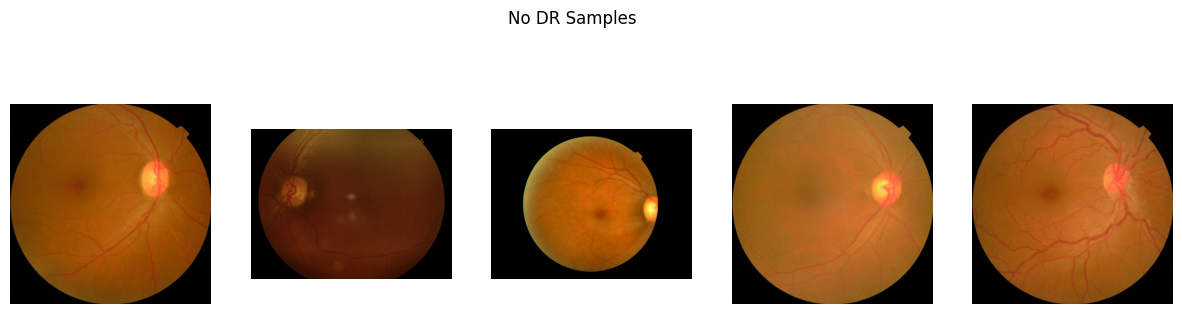

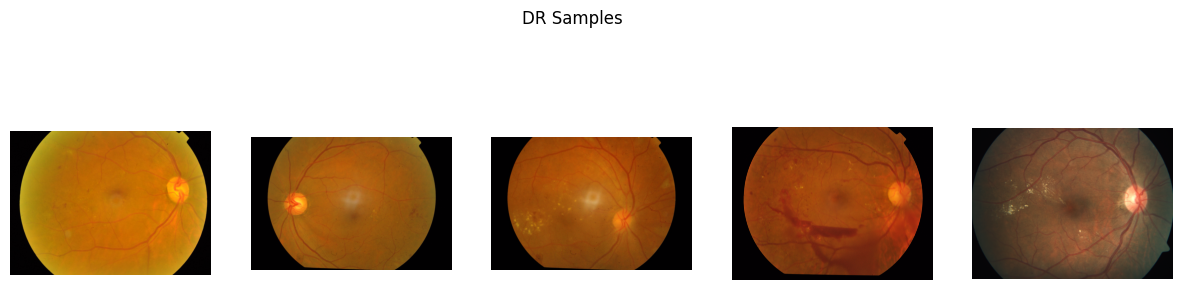

In [8]:
import matplotlib.pyplot as plt
import cv2
import random

def show_samples(folder_path, title):
    images = random.sample(os.listdir(folder_path), 5)

    plt.figure(figsize=(15,4))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

show_samples(train_binary + "/No_DR", "No DR Samples")
show_samples(train_binary + "/DR", "DR Samples")

In [9]:
import cv2
import numpy as np

sample_img_path = os.path.join(train_binary + "/No_DR", os.listdir(train_binary + "/No_DR")[0])

img = cv2.imread(sample_img_path)
print("Image Shape:", img.shape)

Image Shape: (1536, 2048, 3)


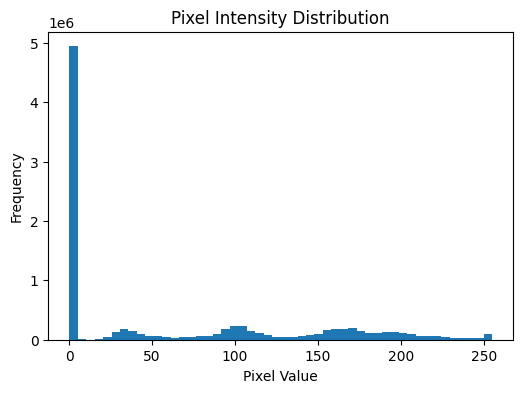

Min Pixel: 0
Max Pixel: 255
Mean Pixel: 62.97502305772569


In [10]:
# Flatten pixel values
pixel_values = img.flatten()

plt.figure(figsize=(6,4))
plt.hist(pixel_values, bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

print("Min Pixel:", np.min(pixel_values))
print("Max Pixel:", np.max(pixel_values))
print("Mean Pixel:", np.mean(pixel_values))

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 16   # reduced for speed

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_binary,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_binary,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 3662 images belonging to 2 classes.
Found 734 images belonging to 2 classes.


In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=3
)

Epoch 1/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.6273 - auc: 0.6745 - loss: 0.6583 - val_accuracy: 0.8774 - val_auc: 0.9490 - val_loss: 0.3969
Epoch 2/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.8222 - auc: 0.9017 - loss: 0.4172 - val_accuracy: 0.9128 - val_auc: 0.9664 - val_loss: 0.3019
Epoch 3/3
229/229 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.8757 - auc: 0.9385 - loss: 0.3368 - val_accuracy: 0.9210 - val_auc: 0.9712 - val_loss: 0.2541


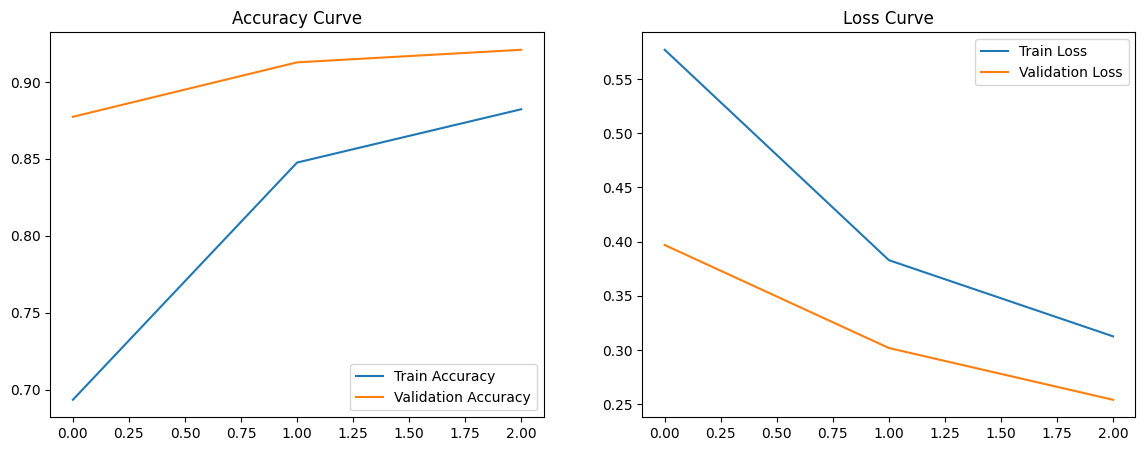

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()

plt.show()

In [29]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [30]:
model.save("/content/drive/MyDrive/dr_binary_model.h5")

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predicted probabilities
y_probs = model.predict(test_generator).ravel()
y_true = test_generator.classes

# Change threshold
threshold = 0.4
y_pred_new = (y_probs > threshold).astype(int)

print("Threshold:", threshold)
print(confusion_matrix(y_true, y_pred_new))
print(classification_report(y_true, y_pred_new))

46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step
Threshold: 0.4
[[337  36]
 [ 18 343]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       373
           1       0.91      0.95      0.93       361

    accuracy                           0.93       734
   macro avg       0.93      0.93      0.93       734
weighted avg       0.93      0.93      0.93       734



46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step


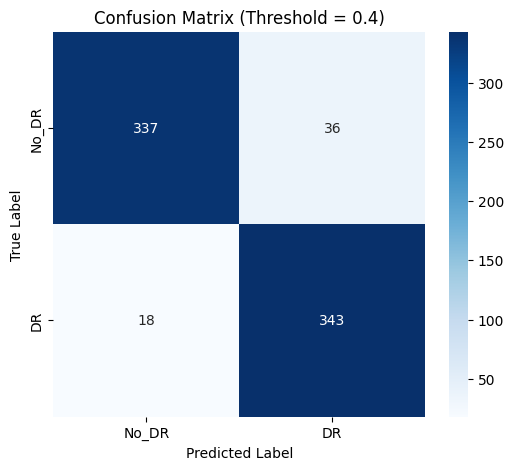

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

threshold = 0.4
y_probs = model.predict(test_generator).ravel()
y_true = test_generator.classes
y_pred = (y_probs > threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No_DR","DR"],
            yticklabels=["No_DR","DR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Threshold = 0.4)")
plt.show()

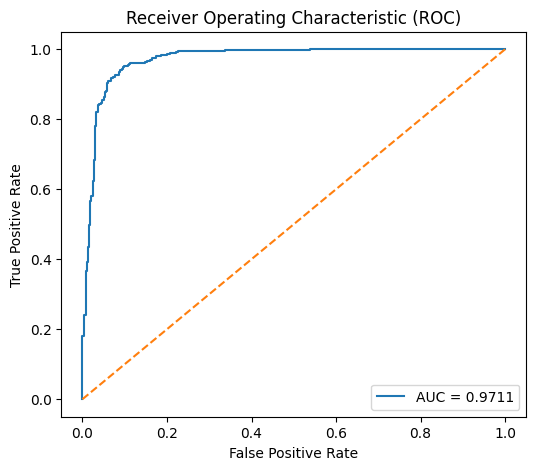

In [33]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.show()

Using last conv layer: Conv_1


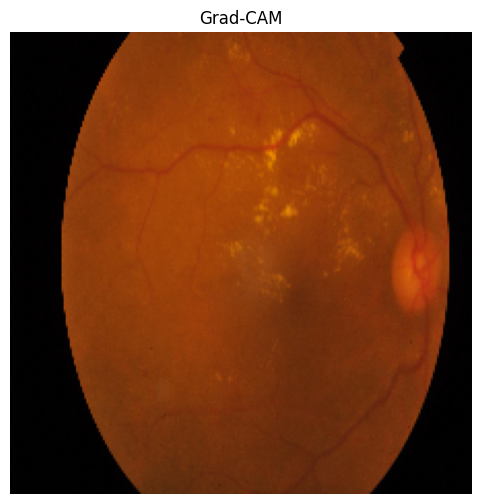

In [35]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Select image
img_path = test_generator.filepaths[10]

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Automatically get last conv layer
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break

print("Using last conv layer:", last_conv_layer)

grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer).output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:,0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

conv_outputs = conv_outputs[0]
heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

heatmap = np.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

heatmap = heatmap.numpy()

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(cv2.resize(heatmap, (224,224)), cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Grad-CAM")
plt.show()

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_image(img_path, threshold=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prob = model.predict(img_array)[0][0]

    label = "DR" if prob > threshold else "No_DR"

    print(f"Prediction: {label}")
    print(f"Probability of DR: {prob:.4f}")

    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [37]:
from google.colab import files
uploaded = files.upload()

Saving images.jpg to images.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Prediction: DR
Probability of DR: 0.8987


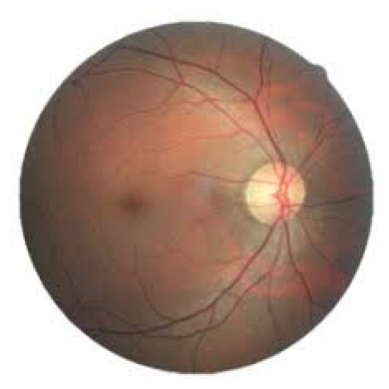

In [38]:
predict_image("images.jpg")